<b> NBA Exploratory Data Analysis and Predicting Hall of Fame probability </b>

Last Updated: 7/23/2020

Is it possible to create a Logistic Regression Model  to accurately predict if an NBA player can make the Hall of Fame? 

In [1]:
# Import necessary packages

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic regression and cross validation libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter('ignore')

In [2]:
# Import datasets 

master_df = pd.read_csv('basketball_master.csv', usecols= ['player_ID', 'firstName', 'lastName', 'pos', 'college'])
awards_df = pd.read_csv('basketball_awards_players.csv',usecols=['playerID', 'award','lgID', 'year'])
allstar_df = pd.read_csv('basketball_player_allstar2.csv',usecols=['player_id','season_id', 'league_id'])
hof_df = pd.read_csv('basketball_hof.csv',usecols=['hofID','year', 'category'])
players_df = pd.read_csv('basketball_players.csv')

<b> Data Cleaning </b>
<br>Matching column names for input data files and filtering for relevant data

In [3]:
# setting player_id as leading column in each dataframe
master_df.columns = ['player_id', 'firstName', 'lastName', 'pos', 'college']

# only show players & awards won in NBA
awards_df = awards_df[awards_df['lgID'] == 'NBA']
players_df = players_df[players_df['lgID'] == 'NBA']
allstar_df = allstar_df[allstar_df['league_id'] == 'NBA']

players_df.rename(columns = {'playerID':'player_id'}, inplace = True)
players_df = players_df.drop(['stint','tmID','lgID','GS','note'], axis=1)

# remove players with zero games played in any given year
players_df = players_df[players_df['GP'] != 0]

# remove player post season columns
cols = [c for c in players_df.columns if c[:4] != 'Post']
players_df = players_df[cols]

awards_df = awards_df.drop(['lgID'], axis=1)
awards_df.columns = ['player_id', 'award', 'year']
hof_df = hof_df[['hofID','category','year']]
hof_df.columns = ['player_id', 'category','year']
hof_df = hof_df[hof_df['category']== 'Player']

Creating dictionary 'player_stats' to store total data per player

In [4]:
# Create DataFrame that captures total player career stats and years played
player_stats = {}
years_played = {}

# Create dictionaries for player stats
for i, row in players_df.iterrows():
    player_id = row['player_id']
    if player_id in player_stats:
        player_stats[player_id]['GP'] = player_stats[player_id]['GP'] + row ['GP']
        player_stats[player_id]['points'] = player_stats[player_id]['points'] + row ['points']
        player_stats[player_id]['rebounds'] = player_stats[player_id]['rebounds'] + row ['rebounds']
        player_stats[player_id]['assists'] = player_stats[player_id]['assists'] + row ['assists']
        player_stats[player_id]['minutes'] = player_stats[player_id]['minutes'] + row ['minutes']
        years_played[player_id].append(row['year'])
        
    else:
        player_stats[player_id] = {}
        player_stats[player_id]['GP'] = row['GP']
        player_stats[player_id]['points'] = row['points']
        player_stats[player_id]['rebounds'] = row['rebounds']
        player_stats[player_id]['assists'] = row['assists']
        player_stats[player_id]['minutes'] = row['minutes']
        years_played[player_id] = []
        years_played[player_id].append(row['year'])
        


In [5]:
# Add the number of years played to player_stats DataFrame
for k, v in years_played.items():
    player_stats[k]['Years_Played'] = len(list(set(v)))
    

We want to track the five key awards from 'awards_df'. These five awards are prestigious and given to a handful of players each season.

In [6]:
# Create DataFrames for each of 5 key awards
mvp = awards_df[awards_df['award'] == 'Most Valuable Player']
roy = awards_df[awards_df['award'] == 'Rookie of the Year']
nba = awards_df[awards_df['award'] == 'All-NBA First Team']
adef = awards_df[awards_df['award'] == 'All-Defensive First Team']
f_mvp = awards_df[awards_df['award'] == 'Finals MVP']

# Include each DataFrame in list 'awards_list'
awards_list = [mvp,roy,nba,adef,f_mvp]

# Initialize lists for each of the above DataFrames
mvp_list = []
roy_list = []
nba_list = []
adef_list = []
f_mvp_list = []

lists = [mvp_list,roy_list, nba_list, adef_list, f_mvp_list]

# Add a count for each award for each player in 'player_stats'
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        player_id = row['player_id']
        award = row['award']
        if player_id in player_stats and player_id in lists[index]:
            player_stats[player_id][award] += 1
        else:
            lists[index].append(player_id)
            player_stats[player_id][award] = 1


The All Star Game is a recognition only 24 players get per year.

In [7]:
# Add a count for each All Star Game appearance for each player in 'player_stats'
allstar_list = [] 

for i, row in allstar_df.iterrows():
    player_id = row['player_id']
    if player_id in player_stats and player_id in allstar_list:
        player_stats[player_id]['AS_game'] += 1
    else:
        allstar_list.append(player_id)
        player_stats[player_id]['AS_game'] = 1

We want to track in dictionary which players have been inducted into Hall of Fame, the most prestigious recognition.

In [8]:
# Indicate which players in 'player_stats' were inducted into Hall of Fame
for i, row in hof_df.iterrows():
    player_id = row['player_id']
    if player_id in player_stats:
        player_stats[player_id]['HoF'] = 1

In [9]:
# Convert 'player_stats' into a DataFrame called stats_df
# stats_df has compiled data from players_df, awards_df, hof_df

stats_df = pd.DataFrame.from_dict(player_stats, orient='index')

In [10]:
# Add a column for playerID from the 'stats_df' index
stats_df['player_id'] = stats_df.index

# Join 'stats_df' and 'master_df'
master_df = master_df.join(stats_df,on='player_id',how='inner', rsuffix='mstr')

# Inspect first rows of 'master_df'
master_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 4903
Data columns (total 19 columns):
player_id                   3749 non-null object
firstName                   3748 non-null object
lastName                    3749 non-null object
pos                         3745 non-null object
college                     3749 non-null object
GP                          3749 non-null int64
points                      3749 non-null int64
rebounds                    3749 non-null int64
assists                     3749 non-null int64
minutes                     3749 non-null int64
Years_Played                3749 non-null int64
All-NBA First Team          97 non-null float64
AS_game                     361 non-null float64
HoF                         100 non-null float64
Most Valuable Player        29 non-null float64
Rookie of the Year          63 non-null float64
All-Defensive First Team    69 non-null float64
Finals MVP                  26 non-null float64
player_idmstr         

In [11]:
# All data in one DataFrame 'df'

df = master_df.drop(['player_idmstr'], axis =1)

# fill null values with 0 in master_df
fill_cols = ['All-NBA First Team', 'AS_game', 'HoF', 'Most Valuable Player', 'Rookie of the Year', 'All-Defensive First Team', 'Finals MVP']

for col in fill_cols:
       df[col] = df[col].fillna(0)
        
master_df.head()


,player_id,firstName,lastName,pos,college,GP,points,rebounds,assists,minutes,Years_Played,All-NBA First Team,AS_game,HoF,Most Valuable Player,Rookie of the Year,All-Defensive First Team,Finals MVP,player_idmstr
0,abdelal01,Alaa,Abdelnaby,F-C,Duke,256,1465,846,85,3200,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,abdelal01
1,abdulka01,Kareem,Abdul-Jabbar,C,UCLA,1560,38387,17440,5660,57446,20,10.0,19.0,1.0,6.0,1.0,5.0,2.0,abdulka01
2,abdulma01,Mahdi,Abdul-Rahman,G,UCLA,724,9087,2146,3555,19202,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,abdulma01
3,abdulma02,Mahmoud,Abdul-Rauf,G,Louisiana State,586,8553,1087,2079,15628,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,abdulma02
4,abdulta01,Tariq,Abdul-Wahad,G-F,San Jose State,236,1830,776,266,4807,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,abdulta01


The dictionary is now cleaned, with null values cleaned. Now we can create new data fields.

In [12]:
# Feature Engineering
# add new features to cleaned data

Per Game statistics are key indicators of performance in basketball. 

In [13]:
# Create per game stats (PPG,RPG,APG)

df['ppg'] = df['points'] / df['GP']
df['rpg'] = df['rebounds'] / df['GP']
df['apg'] = df['assists'] / df['GP']
df['mpg'] = df['minutes'] / df['GP']


<b> Data Visualization </b>
<br> Using histograms and scatter plots to better visualize our player statistics.

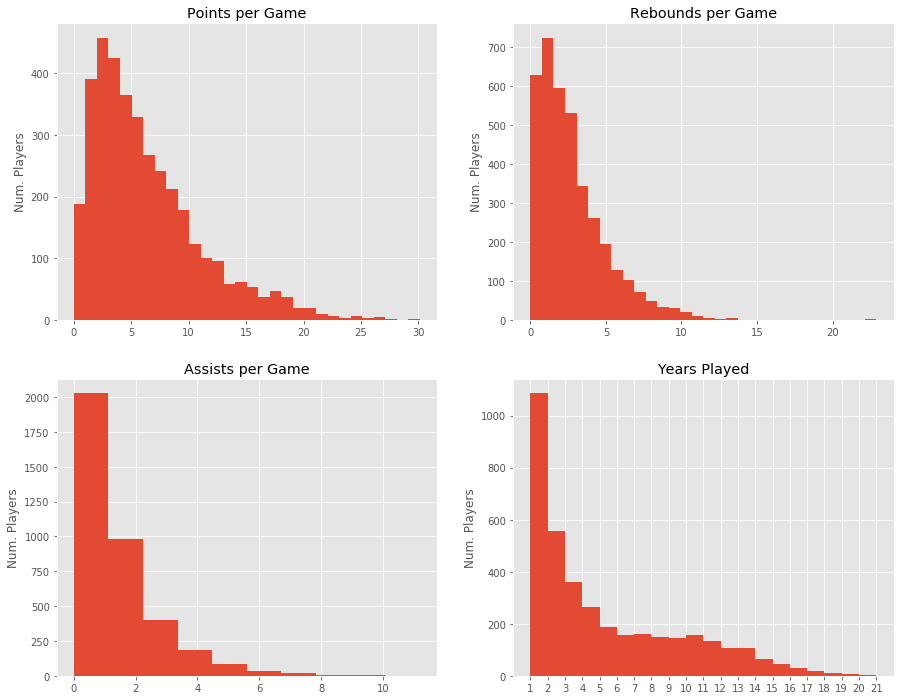

In [14]:
plt.style.use("ggplot")

# visualizing all player career averages
fig = plt.figure(figsize = (15,12))
ax1 = fig.add_subplot (2,2,1)
ax2 = fig.add_subplot (2,2,2)
ax3 = fig.add_subplot (2,2,3)
ax4 = fig.add_subplot (2,2,4)

# distribution plots for all players dataset - points, rebounds, assists, years played
ax1.hist(df['ppg'], bins = 30)
ax1.set_title('Points per Game')
ax1.set_ylabel('Num. Players')

ax2.hist(df['rpg'], bins = 30)
ax2.set_title('Rebounds per Game')
ax2.set_ylabel('Num. Players')

ax3.hist(df['apg'], bins = 10)
ax3.set_title('Assists per Game')
ax3.set_ylabel('Num. Players')

ax4.hist(df['Years_Played'], bins = 20)
ax4.set_title('Years Played')
ax4.set_ylabel('Num. Players')
plt.xticks(np.arange(min(df['Years_Played']), max(df['Years_Played'])+1, 1.0))
plt.show()

df = df.dropna()


In [15]:
# visualization of Hall of Fame players
df_hof = df[df['HoF']==1]
# Print the length of the new DataFrame
print(len(df_hof))

100


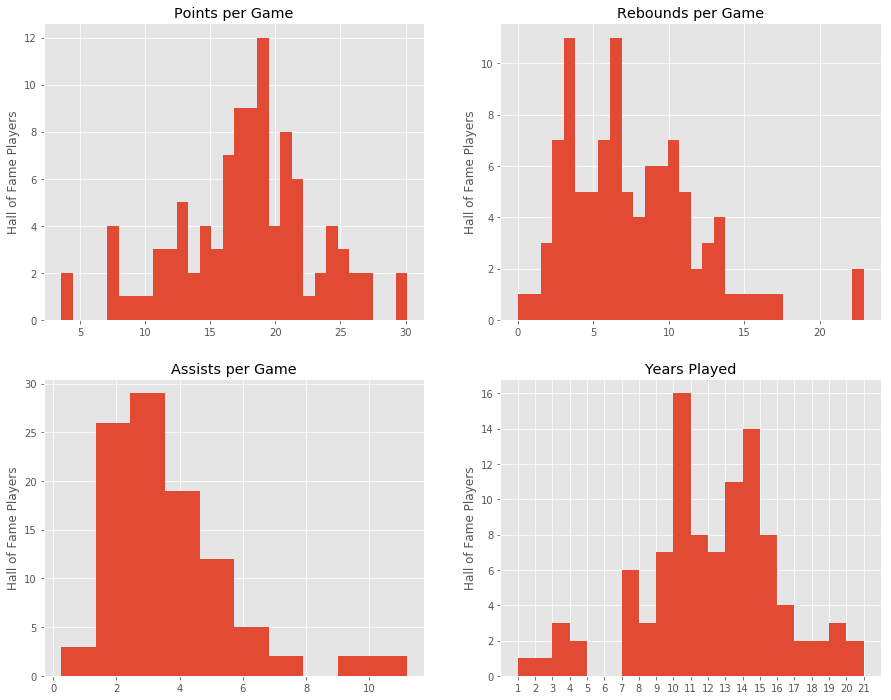

In [16]:
# visualizing Hall of Fame player career averages
fig = plt.figure(figsize = (15,12))
ax1 = fig.add_subplot (2,2,1)
ax2 = fig.add_subplot (2,2,2)
ax3 = fig.add_subplot (2,2,3)
ax4 = fig.add_subplot (2,2,4)

# distribution plots for Hall of Fame players- points, rebounds, assists, years played
ax1.hist(df_hof['ppg'], bins = 30)
ax1.set_title('Points per Game')
ax1.set_ylabel('Hall of Fame Players')

ax2.hist(df_hof['rpg'], bins = 30)
ax2.set_title('Rebounds per Game')
ax2.set_ylabel('Hall of Fame Players')

ax3.hist(df_hof['apg'], bins = 10)
ax3.set_title('Assists per Game')
ax3.set_ylabel('Hall of Fame Players')

ax4.hist(df_hof['Years_Played'], bins = 20)
ax4.set_title('Years Played')
ax4.set_ylabel('Hall of Fame Players')
plt.xticks(np.arange(min(df['Years_Played']), max(df['Years_Played'])+1, 1.0))
plt.show()


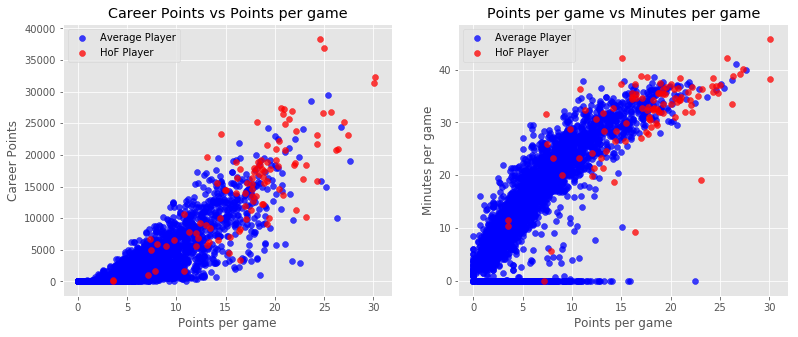

In [17]:
# scatter plot comparison between non-Hall of Fame players and Hall of Fame player stats

df_nonhof = df[df['HoF'] == 0]

fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#Scatter Plot total points vs. ppg)
ax1.scatter(df_nonhof['ppg'], df_nonhof['points'], c='b', alpha = 0.75, label = 'Average Player')
ax1.scatter(df_hof['ppg'], df_hof['points'], c='r', alpha = 0.75, label = 'HoF Player')
ax1.set_title('Career Points vs Points per game')
ax1.set_xlabel('Points per game')
ax1.set_ylabel('Career Points')
ax1.legend()

#Scatter Plot mpg vs. ppg)
ax2.scatter(df_nonhof['ppg'], df_nonhof['mpg'], c='b', alpha = 0.75, label = 'Average Player')
ax2.scatter(df_hof['ppg'], df_hof['mpg'], c='r',alpha = 0.75,label = 'HoF Player')
ax2.set_title('Points per game vs Minutes per game')
ax2.set_xlabel('Points per game')
ax2.set_ylabel('Minutes per game')

ax2.legend()
plt.show()

From the above scater plots, we can see Hall of Fame-inducted players score more on average and play more minutes than players that have not been inducted into the Hall of Fame.

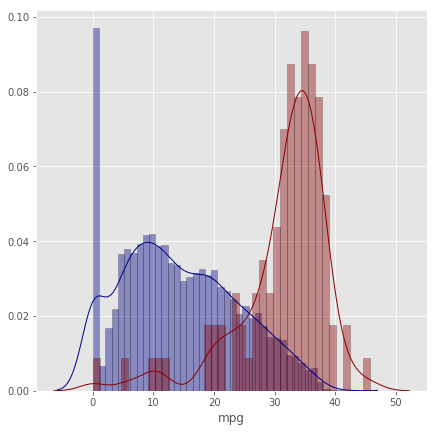

In [18]:
# density plot showing Hall of Fame mpg vs non-Hall of Fame mpg

f, axes = plt.subplots(1, 1, figsize=(7, 7), sharey=True)

# plot of simple distribution of the desired columns

sns.distplot(df_nonhof['mpg'], hist=True, kde=True, bins = 40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})
sns.distplot(df_hof['mpg'], hist=True, kde=True, bins= 40, color = 'darkred', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})


Hall of Fame players average over twice as many minutes per game than non-Hall of Fame players. 
<br> Hall of Fame minutes per game: 31.35
<br> Non-Hall of Fame player minutes per game: 14.39


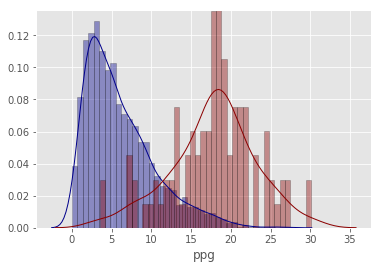

In [19]:
sns.distplot(df_nonhof['ppg'], hist=True, kde=True, bins = 40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})
sns.distplot(df_hof['ppg'], hist=True, kde=True,  bins= 40, color = 'darkred', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 1})

Hall of Fame players average significantly higher points per game than non-Hall of Fame players.
<br> Hall of Fame points per game: 17.77
<br> Non-Hall of Fame player points per game: 6.07

In [20]:
print(df.columns)

Index(['player_id', 'firstName', 'lastName', 'pos', 'college', 'GP', 'points',
       'rebounds', 'assists', 'minutes', 'Years_Played', 'All-NBA First Team',
       'AS_game', 'HoF', 'Most Valuable Player', 'Rookie of the Year',
       'All-Defensive First Team', 'Finals MVP', 'ppg', 'rpg', 'apg', 'mpg'],
      dtype='object')


In [21]:
# Columns to use for Logistic Regression model, ordered by significance
data_list = ['player_id', 'firstName', 'lastName','HoF','ppg', 'rpg', 'apg','points',
        'Most Valuable Player', 'Finals MVP', 'All-NBA First Team', 
        'All-Defensive First Team', 'Rookie of the Year', 'AS_game','GP']

#data DataFrame will be used for model to identify

data = df[data_list]
print(data.head())

   player_id firstName      lastName  HoF        ppg        rpg       apg  \
0  abdelal01      Alaa     Abdelnaby  0.0   5.722656   3.304688  0.332031   
1  abdulka01    Kareem  Abdul-Jabbar  1.0  24.607051  11.179487  3.628205   
2  abdulma01     Mahdi  Abdul-Rahman  0.0  12.551105   2.964088  4.910221   
3  abdulma02   Mahmoud    Abdul-Rauf  0.0  14.595563   1.854949  3.547782   
4  abdulta01     Tariq   Abdul-Wahad  0.0   7.754237   3.288136  1.127119   

   points  Most Valuable Player  Finals MVP  All-NBA First Team  \
0    1465                   0.0         0.0                 0.0   
1   38387                   6.0         2.0                10.0   
2    9087                   0.0         0.0                 0.0   
3    8553                   0.0         0.0                 0.0   
4    1830                   0.0         0.0                 0.0   

   All-Defensive First Team  Rookie of the Year  AS_game    GP  
0                       0.0                 0.0      0.0   256  
1   

In [22]:
# 3744 total players, 100 made Hall of Fame
print(len(data))
print(len(data[data['HoF'] == 1]))

3744
100


There are 3744 unique players in test data set. 100 of those have made the Hall of Fame.

In [23]:
# Create target series
target = data['HoF']

# Create 'features' DateFrame
features = data.drop(['player_id', 'firstName', 'lastName', 'HoF'], axis=1)

<b>Question: Is it possible to create a Logistic Regression Model  to accurately predict if an NBA player can make the Hall of Fame? </b>

In [24]:
# Logistic Regression model
lr = LogisticRegression(C=0.01,class_weight='balanced')

# Create an instance of the KFold class
kf = KFold(features.shape[0], random_state=10)

# Create predictions using cross validation
predictions_lr = cross_val_predict(lr, features, target, cv=kf)

# Convert predictions and target to NumPy arrays
np_predictions_lr = np.asarray(predictions_lr)
np_target = target.as_matrix()


To determine accuracy of the predictions, we observe the four possible prediction scenarios.
<br> These are stasitical measures of the performance of the classification test.
<br> True Positive, True Negative, False Positive, False Negative

In [25]:
# Determine True Positive count
tp_filter_lr = (np_predictions_lr == 1) & (np_target == 1)
tp_lr = len(np_predictions_lr[tp_filter_lr])

# Determine False Negative count
fn_filter_lr = (np_predictions_lr == 0) & (np_target == 1)
fn_lr = len(np_predictions_lr[fn_filter_lr])

# Determine False Positive count
fp_filter_lr = (np_predictions_lr == 1) & (np_target == 0)
fp_lr = len(np_predictions_lr[fp_filter_lr])

# Determine True Negative count
tn_filter_lr = (np_predictions_lr == 0) & (np_target == 0)
tn_lr = len(np_predictions_lr[tn_filter_lr])

# Determine True Positive rate
tpr_lr = tp_lr / (tp_lr + fn_lr)

# Determine False Negative rate
fnr_lr = fn_lr / (fn_lr + tp_lr)

# Determine False Positive rate
fpr_lr = fp_lr / (fp_lr + tn_lr)

# Print each count
print(tp_lr)
print(fn_lr)
print(fp_lr)

# Print each rate
print('True Positivity Rate:', tpr_lr)
print('False Negativity Rate:',fnr_lr)
print('False Positivity Rate:', fpr_lr)

89
11
158
True Positivity Rate: 0.89
False Negativity Rate: 0.11
False Positivity Rate: 0.0433589462129528


The logistic regression model accurately predicted 89% of the Hall of Famers. 158 non-HoF players falsly tested positive. Overall, 4.3% had a false positive rate.

In [26]:
# Predictive data - import new dataframe of players not yet in HoF
new_data_list = ['player_id', 'firstName', 'lastName','HoF','ppg', 'rpg', 'apg', 'points',
        'Most Valuable Player', 'Finals MVP', 'All-NBA First Team', 
        'All-Defensive First Team', 'Rookie of the Year', 'AS_game','GP']

new_data = df_nonhof[new_data_list]

# Create a new features DataFrame

new_features = new_data.drop(['player_id', 'firstName', 'lastName','HoF'], axis=1)


Prediction testing: Using the list of players not yet in Hall of Fame to determine probability using logistic regression model.

In [27]:
# Fit the Logistic Regression model
lr.fit(features, target)

# Estimate probabilities of Hall of Fame induction
probabilities = lr.predict_proba(new_features)

In [28]:
# Convert predictions to a DataFrame
hof_predictions = pd.DataFrame(probabilities[:,1])

# Sort the DataFrame (descending)
hof_predictions = hof_predictions.sort_values(0, ascending=False)

hof_predictions['Probability'] = hof_predictions[0]

# Print highest probability HoF inductees from players not yet in HoF
for i, row in hof_predictions.head(25).iterrows():
    prob = ' '.join(('HoF Probability =', str(row['Probability'])))
    print('')
    print(prob)
    print(new_data.iloc[i,1:27])


HoF Probability = 0.999999679101744
firstName                      Kobe
lastName                     Bryant
HoF                               0
ppg                         25.3953
rpg                         5.28941
apg                         4.66753
points                        29484
Most Valuable Player              1
Finals MVP                        0
All-NBA First Team               10
All-Defensive First Team          9
Rookie of the Year                0
AS_game                          11
GP                             1161
Name: 245, dtype: object

HoF Probability = 0.9999986180442983
firstName                   Timothy
lastName                     Duncan
HoF                               0
ppg                         20.3042
rpg                         11.2799
apg                         3.08551
points                        22558
Most Valuable Player              2
Finals MVP                        3
All-NBA First Team                9
All-Defensive First Team          8


The source data contains statistics through 2011. Thus, we can verify the outcome of players inducted into the Hall of Fame since 2011.

The model accurately predicted the first <b> 10 eligible players </b> to get inducted into the Hall of Fame. It is fair to say many of the players that the model has predicted, will get inducted once they are eligible.